# Рекомендация тарифов

## Введение

В данном проекте в нашем распоряжении есть данные о поведении клиентов, которые перешли на тарифы "Смарт" и "Ультра" (из проекта курса «Статистический анализ данных»). 

Нужно построить модель для задачи классификации, которая выберет подходящий тариф:
- построить модель с максимально большим значением *accuracy* и довести долю правильных ответов по крайней мере до 0.75. 
- проверить *accuracy* на тестовой выборке.

*Предобработка данных не понадобится.*

## Откройте и изучите файл

### Импорт необходимых библиотек

In [1]:
import pandas as pd #импорт пандас
import matplotlib.pyplot as plt #библиотека для построения графиков и задания определенных параметров

from sklearn.model_selection import train_test_split #импорт модуля разделения из специального модуля библиотеки sklearn
from sklearn.tree import DecisionTreeClassifier #импорт модуля дерева решений из специального модуля библиотеки sklearn
from sklearn.metrics import accuracy_score #импорт модуля метрики оценки качества модели
from sklearn.ensemble import RandomForestClassifier #импорт модуля случайного леса
from sklearn.linear_model import LogisticRegression #модуль для логистической регрессии
from sklearn.dummy import DummyClassifier #импорт "глупого" классификатора, для создания baseline модели
#которая поссчитывает наиболее часто встречающийся класс
from sklearn import metrics

from sklearn.metrics import classification_report #импорт метрики, отчет по классификации

### Знакомство с датасетом

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv') #читаем датасет
df.info(); #вывод информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
display(df) #показать датасет

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Датасет состоит из 3214 строк и 5 столбцов. Пустых значений не имеет.

Расшифровка названий столбцов:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Преобразование типа данных

В целом, даже без преобразования типа, с этими данными можно работать, т.к. с ними можно выполнять математические операции. Но все же, неделимые количественные и численные категориальные данные должны иметь целочисленный тип.

Изменим тип данных для `сalls` и `messages` на `int`:

In [4]:
df['calls'] = df['calls'].astype('int') #преобразование типа в целочисленный
df['messages'] = df['messages'].astype('int') #
df.info(); #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


## Разбиение на выборки

Для того, чтобы разбить исходные данные на обучающую, валидационную и тестовую выборку, нужно воспользоваться model_selection из sklearn и импортировать train_test_split. 

Эта функция делит исходную выборку на два набора, тренировочный (обучающий) и валидационный. Чтобы разбить данные на 3 группы, нужно будет воспользоваться сплитом дважды.

*Все импортированные библиотеки / модули находятся в начале проекта, п. 1.1 и добавляются туда в течение всего проекта*

Доля обучающей выборки из исходного датасета - 60%. Доля валидационной и тестовой - по 20%.

Так как сначала делится весь датасет, то суммарная доля для валидационной и тестовой выборок (которые в этой итерации будут считаться валидационной выборкой) равна 40%, или 0,4.

In [5]:
#разделение исходного датасета на две выборки, обучающую и временную валидационную
df_train, df_temp_valid = train_test_split(df, test_size=0.4, random_state=100) 

`random_state` - это опорное число для генератора псевдослучайных чисел, он может быть любым, но в пределах одних и тех же вычислений - одинаковым для каждой итерации.

Таким образом, сначала мы перемешиваем данные, а потом делим с пропорциями 0,6 и 0,4.

Датасет `df_temp_valid` теперь хранит данные для валидационной и тестовой выборок в отношении 1:1.

Применим к нему сплит, разобьем пополам:

In [6]:
#разделение временной валидационной выборки на истинную валидационную и тестовую
df_valid, df_test = train_test_split(df_temp_valid, test_size=0.5, random_state=100) 

Теперь мы имеем 3 выборки:
- `df_train` - обучающая (или тренировочная), содержащая 60% исходных данных;
- `df_valid` - валидационная (или проверочная), содержащая 20% исходных данных;
- `df_test` - тестовая, содержащая 20% исходных данных;

## Исследование моделей

Для начала, нужно определить признаки и целевой признак. 

Целевой принак - тариф. Это категориальный признак, со значением 1 - "Ультра" и 0 - "Смарт".

Признаки - наборы данных о звонках, минутах, сообщениях и трафике - то есть все остальные данные.

In [8]:
features_train = df_train.drop(['is_ultra'], axis=1) #признаки
target_train = df_train['is_ultra'] #целевой признак

features_valid = df_valid.drop(['is_ultra'], axis=1) #признаки
target_valid = df_valid['is_ultra'] #целевой признак

features_test = df_test.drop(['is_ultra'], axis=1) #признаки
target_test = df_test['is_ultra'] #целевой признак

### Дерево решений без указания глубины

Обучим модель не указав глубину дерева

In [9]:
model_tree = DecisionTreeClassifier(random_state=100) #модель дерева решений 
model_tree.fit(features_train, target_train) #обучение модели на тренировочных данных
predictions_tree_train = model_tree.predict(features_train) #предсказание модели по тренировочным данным
result_tree_train = accuracy_score(target_train, predictions_tree_train) #качество предсказанного целевого признака относительно тренировочного
display("Accuracy модели дерева", result_tree_train) #вывод результата предсказания

'Accuracy модели дерева'

1.0

Единица. Очевидно, что модель переобучилась. Проверим это на валидационных данных

In [10]:
predictions_tree_valid = model_tree.predict(features_valid) #предсказание на основе валидационных признаков
result_tree_valid = accuracy_score(target_valid, predictions_tree_valid) #качество предсказанного целевого признака относительно валидационного
display("Accuracy модели дерева", result_tree_valid) #вывод результата предсказания

'Accuracy модели дерева'

0.7402799377916018

Не очень высокое значение качества на валидационной выборке, модель переобучена. Нужно проверить модели разгой глубины дерева на соответствие.

### Дерево решений

In [11]:
accuracy_train_trees_list = [] #создаем пустой список тренировочной оценки точности 

for depth in range(1, 31): #цикл для глубины дерева, до 30
    model_trees = DecisionTreeClassifier(random_state=100, max_depth=depth) #модель дерева решений с меняющейся глубиной
    model_trees.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_trees_train = model_trees.predict(features_train) #предсказание целевого признака на основе тренировочных признаков
    accuracy_train_trees = accuracy_score(target_train, predictions_trees_train) #сравнение реального целевого с предсказанным
    accuracy_train_trees_list.append(accuracy_train_trees) #добавление оценки точности в список
display(accuracy_train_trees_list) #вывод списка

[0.7562240663900415,
 0.7878630705394191,
 0.8013485477178424,
 0.8075726141078838,
 0.8241701244813278,
 0.8303941908713693,
 0.8516597510373444,
 0.8672199170124482,
 0.8775933609958506,
 0.8910788381742739,
 0.9014522821576764,
 0.9154564315352697,
 0.9273858921161826,
 0.9424273858921162,
 0.9569502074688797,
 0.9626556016597511,
 0.9725103734439834,
 0.979253112033195,
 0.9859958506224067,
 0.9875518672199171,
 0.9885892116182573,
 0.9911825726141079,
 0.991701244813278,
 0.9922199170124482,
 0.9937759336099585,
 0.9963692946058091,
 0.9984439834024896,
 0.9994813278008299,
 1.0,
 1.0]

Мы видим, что модель с увеличением глубины начинает переобучаться. На глубине 29 - достигает максимума. Проверим на валидационной выборке и построим общий график

In [12]:
accuracy_valid_trees_list = [] #создаем пустой список валидационной оценки точности 

for depth in range(1, 31): #цикл для глубины дерева, до 30
    model_trees = DecisionTreeClassifier(random_state=100, max_depth=depth) #модель дерева решений с меняющейся глубиной
    model_trees.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_trees_valid = model_trees.predict(features_valid) #предсказание целевого признака на основе валидационных признаков
    accuracy_valid_trees = accuracy_score(target_valid, predictions_trees_valid) #сравнение реального целевого с предсказанным
    accuracy_valid_trees_list.append(accuracy_valid_trees) #добавление оценки точности в список
#display(accuracy_valid_trees_list)

In [13]:
depth_list = list(range(1, 31)) #создаем список значений глубины дерева

In [14]:
df_trees = pd.DataFrame({ #созаем датафрейм
    'Depth': depth_list, #глубина - из списка
    'Train_accuracy': accuracy_train_trees_list, #качество тренировочных данных
    'Valid_accuracy': accuracy_valid_trees_list #качество валидационных данных
}) #

In [15]:
display(df_trees) #вывод датасета

,Depth,Train_accuracy,Valid_accuracy
0,1,0.756224,0.758942
1,2,0.787863,0.799378
2,3,0.801349,0.818040
3,4,0.807573,0.810264
4,5,0.824170,0.807154
5,6,0.830394,0.791602
6,7,0.851660,0.780715
7,8,0.867220,0.785381
8,9,0.877593,0.793157
9,10,0.891079,0.780715


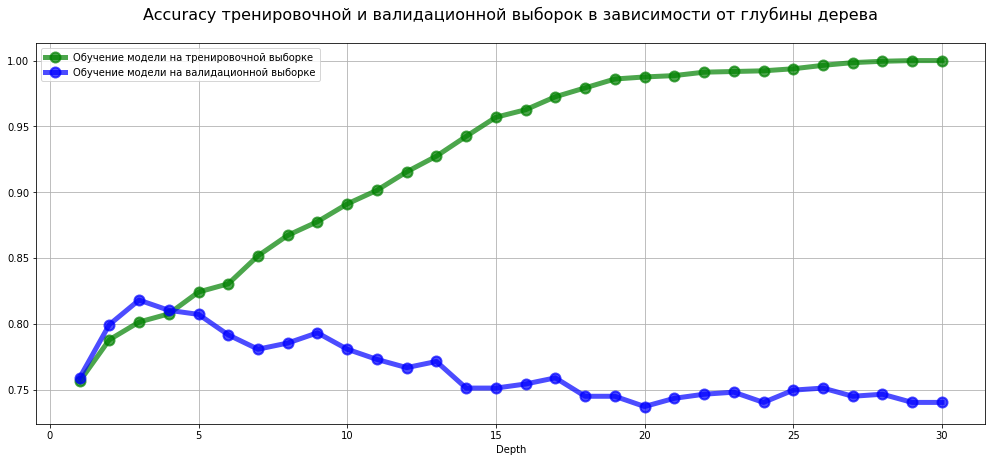

In [16]:
ax = df_trees.plot( #строим график plot
    x='Depth', y='Train_accuracy', #оси Х и Y
    style='o-g', sharex=False, grid=True, alpha=0.7, #линия с точками, сетка, прозрачность 0.7
    label="Обучение модели на тренировочной выборке", #легенда
    lw=5, mew=2, ms=10, figsize=(17, 7)); #толщина линии, величина точек, размеры графика

df_trees.plot(
    x='Depth', y='Valid_accuracy', style='o-b', sharex=False, grid=True,
    alpha=0.7, label="Обучение модели на валидационной выборке",
    lw=5, mew=2, ms=10, figsize=(17, 7), ax=ax)\
.set_title(
    'Accuracy тренировочной и валидационной выборок в зависимости от глубины дерева' + "\n", #название графика
    fontsize = 16, color = 'Black'); #размер шрифта, цвет

In [17]:
#вывод на экран лучшего значения оценки точности для дерева решений
display(f"Наилучший результат обучения модели находится при значении depth=3 и равен {df_trees['Valid_accuracy'].max()}") 

'Наилучший результат обучения модели находится при значении depth=3 и равен 0.8180404354587869'

Мы видим на графике, что если модель, обученная на тренировочных данных начинает переобучаться, то она начинает предсказывать все хуже. Это происходит потому, что модель "заучивает" значения. 

Модель хорошо обучилась на глубине дерева 2-5, при этом, на значениях глубины 2-4 оценка точности предсказаний выше, чем на тренировочных данных. На глубине 4 они почти равны.

### Случайный лес

In [18]:
accuracy_train_forest_list = [] #создаем пустой список тренировочной оценки точности 

for value in range(1, 41): #цикл для количества деревьев, до 30
    model_forest = RandomForestClassifier(random_state=100, n_estimators=value) #модель леса с меняющимся количеством деревьев
    model_forest.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_forest_train = model_forest.predict(features_train) #предсказание целевого признака на основе тренировочных признаков
    accuracy_train_forest = accuracy_score(target_train, predictions_forest_train) #сравнение реального целевого с предсказанным
    accuracy_train_forest_list.append(accuracy_train_forest) #добавление оценки точности в список
#display(accuracy_train_forest_list) #вывод списка

In [19]:
accuracy_valid_forest_list = [] #создаем пустой список валидационной оценки точности 

for value in range(1, 41): #цикл для глубины дерева, до 30
    model_forest = RandomForestClassifier(random_state=100, n_estimators=value) #модель леса с меняющимся количеством деревьев
    model_forest.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_forest_valid = model_forest.predict(features_valid) #предсказание целевого признака на основе тренировочных признаков
    accuracy_valid_forest = accuracy_score(target_valid, predictions_forest_valid) #сравнение реального целевого с предсказанным
    accuracy_valid_forest_list.append(accuracy_valid_forest) #добавление оценки точности в список
#display(accuracy_valid_trees_list)

In [20]:
value_list = list(range(1, 41)) #создаем список значений глубины дерева

In [21]:
df_forest = pd.DataFrame({ #созаем датафрейм
    'Value': value_list, #глубина - из списка
    'Train_accuracy': accuracy_train_forest_list, #качество тренировочных данных
    'Valid_accuracy': accuracy_valid_forest_list #качество валидационных данных
}) #

In [22]:
display(df_forest) #вывод датасета

,Value,Train_accuracy,Valid_accuracy
0,1,0.900934,0.734059
1,2,0.898340,0.769829
2,3,0.954876,0.772939
3,4,0.949170,0.779160
4,5,0.971473,0.771384
5,6,0.964212,0.797823
6,7,0.980290,0.783826
7,8,0.971473,0.790047
8,9,0.982365,0.790047
9,10,0.978216,0.802488


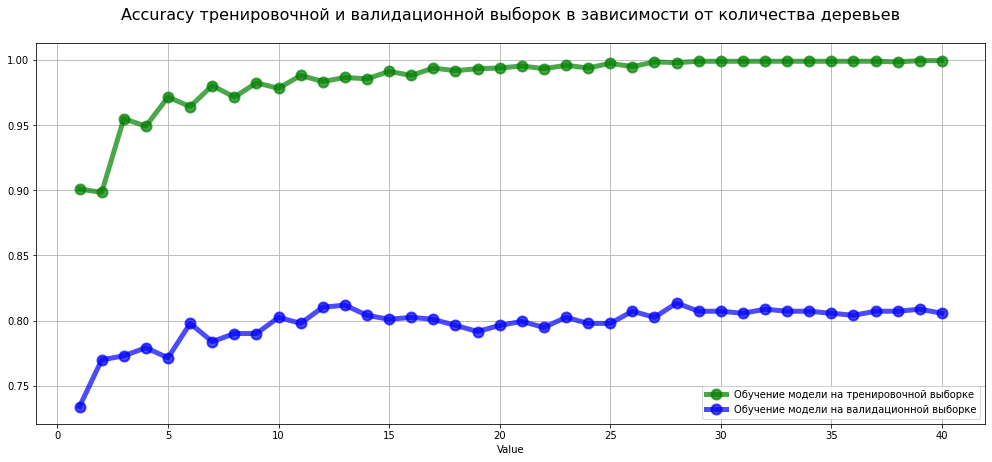

In [23]:
ax = df_forest.plot( #строим график plot
    x='Value', y='Train_accuracy', #оси Х и Y
    style='o-g', sharex=False, grid=True, alpha=0.7, #линия с точками, сетка, прозрачность 0.7
    label="Обучение модели на тренировочной выборке", #легенда
    lw=5, mew=2, ms=10, figsize=(17, 7)); #толщина линии, величина точек, размеры графика

df_forest.plot(
    x='Value', y='Valid_accuracy', style='o-b', sharex=False, grid=True,
    alpha=0.7, label="Обучение модели на валидационной выборке",
    lw=5, mew=2, ms=10, figsize=(17, 7), ax=ax)\
.set_title(
    'Accuracy тренировочной и валидационной выборок в зависимости от количества деревьев' + "\n", #название графика
    fontsize = 16, color = 'Black'); #размер шрифта, цвет

In [24]:
df_forest.sort_values(by='Valid_accuracy', ascending=False).head(3)

,Value,Train_accuracy,Valid_accuracy
27,28,0.997925,0.813375
12,13,0.986515,0.811820
11,12,0.983402,0.810264


Самое высокое качество модели при 28 деревьях. Но это количество достаточно высокое, а оценка не намного выше, чем при 13 деревьях. После 28 деревьев значения оценки модели выходят на плато и колеблются в пределах погрешности. Это значит, что увеличение количества деревьев не приведет ни к чему кроме замедления работы.

Можно сказать, что, несмотря на то, что 13 деревьев не дают самое высокое значение оценки точности, они являются самым оптимальным решением случайного леса. 

### Логистическая регрессия

In [25]:
display((df['is_ultra'].sum() / df['is_ultra'].count()).round(1)) #количество клиентов ультра к общему числу пользователей

0.3

Мы посчитали количество единиц в столбце `is_ultra` исходного датасета. Их около 30%. Для логистической регрессии есть параметр `class_weight`, который регулирует вес класса. Т.к. класса 1 меньше в 3 раза, чем класса 0, попробуем их сбалансировать.

In [26]:
model_regression = LogisticRegression( #логистическая регрессия (для категориальных данных)
    random_state=100, 
    solver='lbfgs', #решатель, алгоритм, который строит модель. по умолчанию (можно не указывать)
    C=1.0, #обратная сила регуляризации. по умолчанию (можно не указывать)
    penalty='l2', #штраф. по умолчанию (можно не указывать)
    class_weight={0:0.3, 1:0.7},
    max_iter=1000) #максимальное количество итераций 1000, 
model_regression.fit(features_train, target_train) #обучение модели на тренировочных данных
model_regression.score(features_valid, target_valid) #качество методом score на основе предсказанных данных и 
#целевого признака валидационной выборки

0.39035769828926903

Параметр `solver='lbfgs'` - это алгоритм, по которому строится модель. Он идет по умолчанию и показывает довольно высокое значение. Оставляем его.

Параметр `C` в регрессии - положительный с типа `float`, при маленьких значениях, показывает худший результат.

Параметр `penalty='l2'` идет по умолчанию к параметру `solver='lbfgs'`. Параметр `solver='lbfgs'` может принимать значения `penalty='l2'` и `penalty='none'`.

Получилось очень низкое значение `accuracy`. Вернем значение по умолчанию.

In [27]:
model_regression = LogisticRegression( #логистическая регрессия (для категориальных данных)
    random_state=100, 
    solver='lbfgs', #решатель, алгоритм, который строит модель. по умолчанию (можно не указывать)
    C=1.0, #обратная сила регуляризации. по умолчанию (можно не указывать)
    penalty='l2', #штраф. по умолчанию (можно не указывать)
    class_weight=None,
    max_iter=1000) #максимальное количество итераций 1000, 
model_regression.fit(features_train, target_train) #обучение модели на тренировочных данных
model_regression.score(features_valid, target_valid) #качество методом score на основе предсказанных данных и 
#целевого признака валидационной выборки

0.7573872472783826

In [28]:
model_regression.coef_ #значимость признаков

array([[7.80476551e-05, 1.47259161e-03, 9.56581927e-03, 3.51660057e-05]])

Таким образом, наибольшую значимость при обучении модели имеет количество сообщений, затем - количество минут и количество звонков. Нименьшее влияние имеет трафик.

Ценность одной СМС для оценки тарифа равна:
- около 122 звонков;
- около 6.5 минут;
- 272 МБ интернет трафика.

Пример:

In [29]:
model_regression.predict([[0, 0, 1000, 0]]) #предсказываем с помощью лог.регрессии, какой тариф предложит сеть с 1000 СМС

array([1])

In [30]:
model_regression.predict([[0, 1000, 0, 0]]) #предсказываем с помощью лог.регрессии, какой тариф предложит сеть с 1000 минут

array([0])

- 1000 СМС приводит нас к тарифу "Ультра"
- 1000 минут оставляет нас на тарифе "Смарт".

Пока логистическая регрессия показывает худший результ из всех моделей.

## Проверка лучшей модели на тестовой выборке

Проверим модель с наибольшим accuracy на тестовой выборке:
- дерево решений с глубиной depth=3;

### Тестирование дерева решений

Создаем модель с глубиной дерева `depth=3`, обучаем ее на тренировочной выборке, предсказывсаем по обученной модели целевой признак и сравниваем его с тестовым целевым признаком

In [31]:
model_trees = DecisionTreeClassifier(random_state=100, max_depth=3) #модель дерева решений с заданной глубиной
model_trees.fit(features_train, target_train) #обучение модели на тренировочной выборке
predictions_trees_test = model_trees.predict(features_test) #предсказание целевого признака на основе тестовых признаков
accuracy_test_trees = accuracy_score(target_test, predictions_trees_test) #сравнение реального целевого с предсказанным
accuracy_test_trees #вывод результата

0.7651632970451011

Accuracy дерева решений с `depth=3` для тестовой выборки равен `0.7651632970451011`

### Precision, recall

Оценим точность (precision) и полноту (recall) полученных данных.

In [32]:
print(metrics.confusion_matrix(target_test, predictions_trees_test));

# Print the precision and recall, among other metrics
print(metrics.classification_report(target_test, predictions_trees_test, digits=3))

[[412  35]
 [116  80]]
              precision    recall  f1-score   support

           0      0.780     0.922     0.845       447
           1      0.696     0.408     0.514       196

    accuracy                          0.765       643
   macro avg      0.738     0.665     0.680       643
weighted avg      0.754     0.765     0.744       643



Мы видим, что precision для каждого класса довольно высокий (значит, модель делает достаточно корректных предсказаний класса Positive и, в то же время, меньше неверных Positive классификаций для каждого класса), но 1 предсказываются хуже (в т.ч. потому что их в 2,5 раа меньше.

По recall видно, что имеются некоторые проблемы с угадыванием 1 (т.е. слишком большое количество ложноотрицательных значений).

- macro avg считает метрики каждого класса и находит их "невзвешенное" среднее;
- weighted avg считает метрики каждого класса и находит их "взвешенное" среднее - считает дисбаланс классов.

## Выводы

В проекте мы научились рабивать исходные данные на несколько выборок, для того, чтобы по этим выборкам мы могли обучать модель, предсказывать значения и проверять их. 

Было исследовано несколько моделей для машинного обучения, таких как:
- Дерево решений, в т.ч. при изменении самого важного гиперпараметра `depht`, от которого зависит результат обучения. Будет ли модель переучена или недоучена. Боло получено самое высокое значение качества, которое выше порогового 0,75. `Accuracy > 0,75`
- Случайный лес, в котором мы подбирали оптимальное значение параметра `n_estimators`, от которого зависит качество, но, в то же время, зависит и время/ресурсозатратность получения этой оценки. Получено высокое значение качества для модели, но в ущерб скорости работы. `Accuracy > 0,75`
- Логистическая регрессия, которая показала себя хуже остальных моделей в предсказании, но имеет массу преимуществ, таких как: устойчивость к переобучению, высокая скорость работы. Пороговое начение качества не достигнуто для тестовой выборки, `accuracy < 0,75`.

Для бизнеса, более устойчивой и наиболее стабильной моделью является случайный лес. Но в то же время, она показала меньший результат, чем дерево решений. В то же время, на расчет леса тратится много ресурсов. 

В текущем проекте именно модель дерева решений должна анализировать пользователей архивных тарифов, чтобы предложить им новые условия, т.к. эта модель показала самый высокий результат `accuracy` для валидационной выборки и успешно прошла проверку на тестовой выборке.

## Проверка модели на адекватность

In [34]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=100) #создание baseline модели - наиболее часто встречающееся
dummy_clf.fit(features_train, target_train) #обучение модели
dummy_clf.score(features_train, target_train) #подсчет результата

0.6939834024896265

Проверяем, как себя ведет `accuracy` при предсказывании тестовых значений на основе модели, обученной на обучающих данных с помощью стратегии наибольшей частоты модуля `DummyClassifier`.

Значение accuracy baseline оказалось меньше, чем значение для моделей, в т.ч. дерева решений. Значит модели прошли проверку на вменяемость.